In [1]:
from pyMuellerMat.Instruments import sphere
import glob
import numpy as np
from astropy.io import fits
import copy
import pyMuellerMat.common_mm_functions as cmf
import matplotlib.pyplot as plt
from pyklip import klip

#Some nicer printing options to avoid machine errors
np.set_printoptions(precision=5)
np.set_printoptions(suppress=True)

### In this notebook we will look at TW Hya data obtained on 2015-04-01, program ID: 095.C-0273(D). The data has already been passed through gasgano to split it into 'left' and 'right' frames

In [2]:
#Read in the data
datadir='/Users/mamillar/Data/SPHERE/TWHya/calibrated/'
left_fns = glob.glob(datadir+"*left*.fits")
left_fns = left_fns[24:-3]
n_left = len(left_fns)
print("Found {} 'left' filenames".format(n_left))

right_fns = glob.glob(datadir+"*right*.fits")
right_fns = right_fns[24:-3]
n_right = len(right_fns)
print("Found {} 'right' filenames".format(n_right))

Found 24 'left' filenames
Found 24 'right' filenames


In [47]:
#Generate the sphere mueller matrix model - based on Rob van Holstein's master's thesis
sphere_mm = sphere.make_mm()

In [48]:
#Read in the files and relevant header keywords
left_data = np.zeros([n_left,1024,1024])
right_data = np.zeros([n_right,1024,1024])

xcenter_left = np.zeros([n_left])
ycenter_left = np.zeros([n_left])
hwp_pa_left = np.zeros([n_left])
derot_pa_left = np.zeros([n_left])
left_parangle = np.zeros([n_left])
left_alt = np.zeros([n_left])

xcenter_right = np.zeros([n_right])
ycenter_right = np.zeros([n_right])
hwp_pa_right = np.zeros([n_right])
derot_pa_right = np.zeros([n_right])
right_parangle = np.zeros([n_left])
right_alt = np.zeros([n_left])

for i in range(n_left):
    left_fits = fits.open(left_fns[i])
    left_data[i] = np.sum(left_fits[0].data,axis=0)
    xcenter_left[i] = left_fits[0].header['ESO SEQ CORO XC']
    ycenter_left[i] = left_fits[0].header['ESO SEQ CORO YC']
    hwp_pa_left[i] = left_fits[0].header['ESO INS4 DROT3 BEGIN'] - 152.15#adding 22.5 based on TW Hya
    derot_pa_left[i] = left_fits[0].header['ESO INS4 DROT2 BEGIN']
    left_parangle[i] = left_fits[0].header["ESO TEL PARANG END"]
    left_alt[i] = left_fits[0].header['ESO TEL ALT']
    
    right_fits = fits.open(right_fns[i])
    right_data[i] = np.sum(right_fits[0].data,axis=0)
    xcenter_right[i] = right_fits[0].header['ESO SEQ CORO XC']
    ycenter_right[i] = right_fits[0].header['ESO SEQ CORO YC']
    hwp_pa_right[i] = right_fits[0].header['ESO INS4 DROT3 BEGIN'] - 152.15
    derot_pa_right[i] = right_fits[0].header['ESO INS4 DROT2 BEGIN']
    right_parangle[i] = right_fits[0].header["ESO TEL PARANG END"]
    right_alt[i] = right_fits[0].header['ESO TEL ALT']

Text(0,0.5,u'Telescope Altitude')

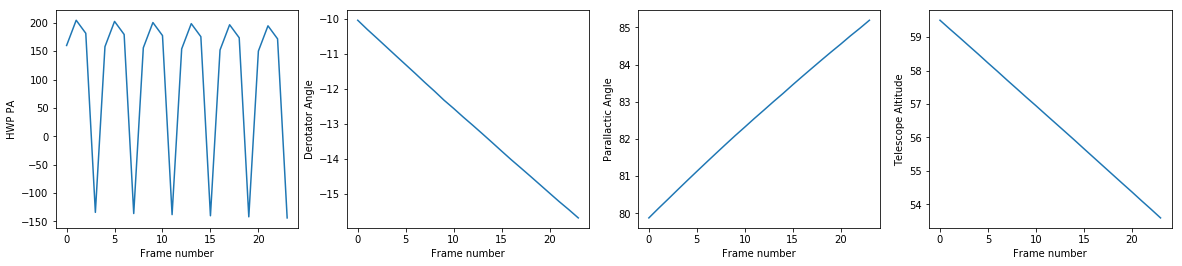

In [42]:
## Plot the relevant angles
fig = plt.figure(figsize=(20,4))

ax1 = fig.add_subplot(141)
plt.plot(hwp_pa_left)
plt.xlabel("Frame number")
plt.ylabel("HWP PA")

ax1 = fig.add_subplot(142)
plt.plot(derot_pa_left)
plt.xlabel("Frame number")
plt.ylabel("Derotator Angle")

ax1 = fig.add_subplot(143)
plt.plot(left_parangle)
plt.xlabel("Frame number")
plt.ylabel("Parallactic Angle")

ax1 = fig.add_subplot(144)
plt.plot(left_alt)
plt.xlabel("Frame number")
plt.ylabel("Telescope Altitude")

In [8]:
#Touch up the centering
xcenter_right[:] = 512
ycenter_right[:] = 512

xcenter_left[:] = 512
ycenter_left[:] = 512

In [9]:
## Unnecessary - in this case. 

# Line up the right with the left side 
# for i in range(n_left):
#     right_data[i] = klip.align_and_scale(right_data[i],[xcenter_left[i],ycenter_left[i]],
#                                          old_center=[xcenter_right[i],ycenter_right[i]])   

#The center of all the psfs now
xcen = xcenter_left[0]
ycen = ycenter_left[0]

In [25]:
#Make the single sum and difference arrays
diff_arr = left_data-right_data
sum_arr = left_data+right_data

In [26]:
#Make the double sum and difference arrays
dd_measurements = np.zeros([n_left,1024,1024]) 
dd_measurements[1::2] = 0.5*(diff_arr[::2]-diff_arr[1::2])
dd_measurements[::2] = 0.5*(sum_arr[::2]+sum_arr[1::2])

In [27]:
#The mueller matrix for each configuration
mm = np.zeros([n_left,4,4]) 

#This is the measurement matrix for the sums and single differences
measurement_matrix = np.zeros([n_left+n_right,4])

for i in range(n_left):
    
    #Evaluate the sphere mueller matrix model. 
    sphere_mm.master_kwarg_dict['SkyRotation']['pa'] = left_parangle[i]
    sphere_mm.master_kwarg_dict['Sphere_Derotator']['theta'] = derot_pa_left[i]
    sphere_mm.master_kwarg_dict['Sphere_HWP']['theta'] = hwp_pa_left[i]
    sphere_mm.master_kwarg_dict['TelescopeAlt']['pa'] = left_alt[i]
    mm[i] = sphere_mm.evaluate()
    
    measurement_matrix[i*2,:] = mm[i,:,:][0] #Grab the I component - Similar to van Holsten Masters Eq'n 6.12 but for single sum. 
    measurement_matrix[i*2+1,:] = mm[i,:,:][1] #Grab the Q component - Similar to van Holsten Masters Eq'n 6.13 but for single difference. 


In [46]:
#Let's take a look at the measurement matrix
#It should approximately follow the following sequence: 
#[SingleSum,
# SingleDifferenceQ,
# SingleSum,
# SingleDifferenceNegativeQ,
# SingleSum,
# SingleDifferenceU,
# SingleSum,
# SingleDifferenceNegativeU,
# Repeat]

print(measurement_matrix)

[[ 0.9801  -0.00477  0.0023   0.0113 ]
 [-0.00119  0.85957 -0.32625  0.32634]
 [ 0.98009  0.00057 -0.00118 -0.01109]
 [ 0.00304 -0.85252  0.3237  -0.34676]
 [ 0.98007  0.0084  -0.00303  0.00358]
 [-0.00017  0.28352 -0.22972 -0.90479]
 [ 0.98012 -0.01186  0.00614 -0.00388]
 [ 0.00162 -0.27551  0.28947  0.89   ]
 [ 0.98011 -0.00583  0.00285  0.01127]
 [-0.00188  0.83771 -0.34892  0.35821]
 [ 0.98009  0.00161 -0.00173 -0.01101]
 [ 0.00228 -0.83148  0.34254 -0.3783 ]
 [ 0.98008  0.00822 -0.00321  0.00479]
 [-0.00098  0.30532 -0.25102 -0.89195]
 [ 0.98013 -0.01161  0.00629 -0.00509]
 [ 0.00095 -0.29697  0.30843  0.87663]
 [ 0.98012 -0.00688  0.00347  0.01111]
 [-0.00261  0.81452 -0.36949  0.38968]
 [ 0.98009  0.00261 -0.00234 -0.01081]
 [ 0.0015  -0.80908  0.36061 -0.40885]
 [ 0.98008  0.00793 -0.00333  0.00598]
 [-0.0018   0.32482 -0.27305 -0.87849]
 [ 0.98013 -0.01127  0.00638 -0.00623]
 [ 0.00026 -0.31444  0.32772  0.86344]
 [ 0.98012 -0.00786  0.00413  0.01083]
 [-0.00333  0.79068 -0.38

### We can see that for what should be the SingleU frames, it believes it is actually measuring Stokes V, rather than U. This is likely due to the derotator, which behaves like a QWP in 'H' band, and we're at low derotator angles (~10-15 degrees), so it should be converting V into U. This is somewhat at adds with the fact that when we look at the double difference images (below) there's clearly a strong signal in the U component. If it were actually converting Stokes V to U, then we would expect the measured 'U' to be virtually non-existent.

In [29]:
#Now the double sum/difference measurement matrix
dd_measurement_matrix = np.zeros([n_left,4])

## The sum components
dd_measurement_matrix[::2,:] = 0.5*(measurement_matrix[::4,:]+measurement_matrix[2::4,:])
## Now the diff components
dd_measurement_matrix[1::2,:] = 0.5*(measurement_matrix[1::4,:]-measurement_matrix[3::4,:])

In [30]:
### Subtract the instrumental polarization from each double difference. 
for i in range(dd_measurements.shape[0]/2):
    #Pretend there is only a Stokes I input and multiply that by the measurement matrix. 
    dd_measurements[i*2+1,:,:] -= dd_measurements[i*2,:,:]*np.matmul(dd_measurement_matrix[i*2+1,:],[1,0,0,0])

### Remove it from the measurement matrix: 
dd_measurement_matrix[1::2,::4]=0

In [43]:
#Let's look at the new measurement matrix
dd_measurement_matrix

array([[ 0.9801 , -0.0021 ,  0.00056,  0.00011],
       [ 0.     ,  0.85605, -0.32498,  0.33655],
       [ 0.9801 , -0.00173,  0.00155, -0.00015],
       [ 0.     ,  0.27952, -0.25959, -0.8974 ],
       [ 0.9801 , -0.00211,  0.00056,  0.00013],
       [ 0.     ,  0.83459, -0.34573,  0.36826],
       [ 0.9801 , -0.0017 ,  0.00154, -0.00015],
       [ 0.     ,  0.30114, -0.27972, -0.88429],
       [ 0.9801 , -0.00213,  0.00057,  0.00015],
       [ 0.     ,  0.8118 , -0.36505,  0.39927],
       [ 0.9801 , -0.00167,  0.00152, -0.00013],
       [ 0.     ,  0.31963, -0.30039, -0.87096],
       [ 0.98011, -0.00216,  0.00057,  0.00017],
       [ 0.     ,  0.78846, -0.38185,  0.42919],
       [ 0.98011, -0.00164,  0.0015 , -0.00012],
       [ 0.     ,  0.33786, -0.32251, -0.85606],
       [ 0.98011, -0.00217,  0.00058,  0.00019],
       [ 0.     ,  0.7641 , -0.39759,  0.45798],
       [ 0.98011, -0.00163,  0.00148, -0.0001 ],
       [ 0.     ,  0.35296, -0.34484, -0.84116],
       [ 0.98012, -0

### That Stokes Y, rather than Stokes U is still there

In [32]:
# Rotate all the frames north up. 

#The sign on the rotation(negative) and the flipx=True are based on trial and error
flipx=False

# Since we're combining two frames for each double different (or double sum),
# we'll rotate by the average of the two. 
parangs = 0.5*(right_parangle[0::2]+right_parangle[1::2])

## Rotate North up
for i in range(dd_measurements.shape[0]):
    #TODO: For now this relies on pyklip. I should eventually pick a more general function. 
    dd_measurements[i,:,:]=klip.rotate(dd_measurements[i,:,:],-derot_pa_left[i//2],[xcen,ycen],flipx=flipx)

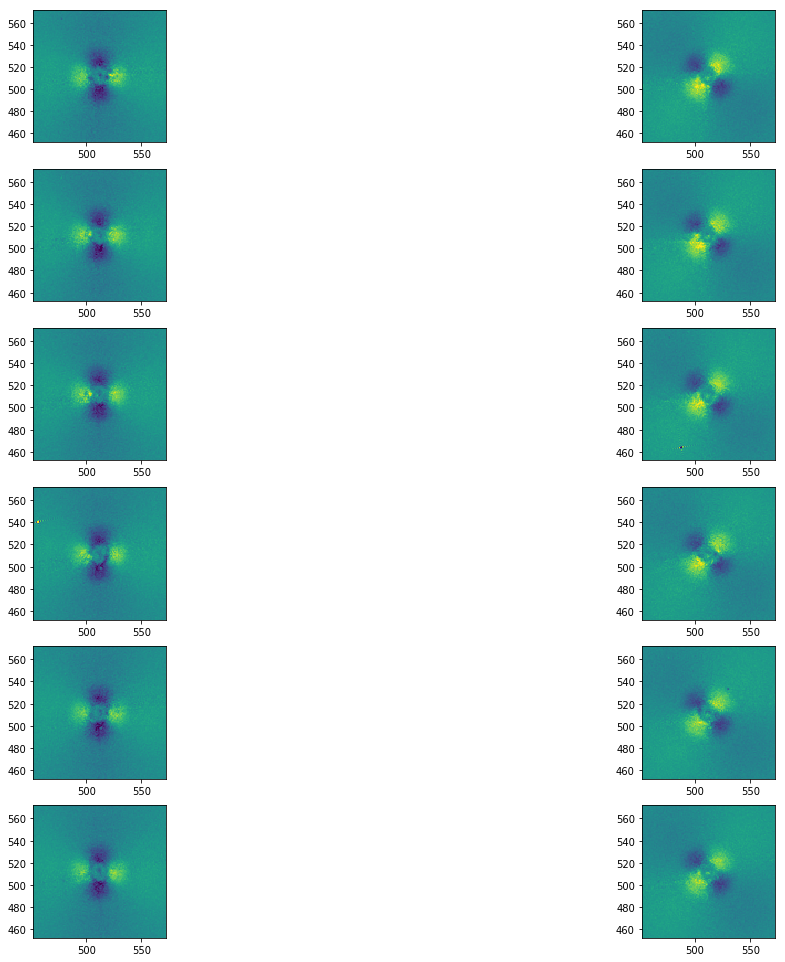

In [44]:
## Plot the Q and U images before any correction 
fig = plt.figure(figsize=(20,20))
for i in np.arange(1,n_left,2):
    ax = fig.add_subplot(7,2,i/2+1)
    plt.imshow(dd_measurements[i],vmin=-500,vmax=500)
    plt.xlim(xcen-boxsize/2,xcen+boxsize/2)
    plt.ylim(ycen-boxsize/2,ycen+boxsize/2)

### The signals between the Q and U are nearly identical in strength, that can't be the case if we're actually measuring a large Stokes V rather than U. 

In [33]:
#Now do the inversion. 

#And get the inverse of the measurement matrix
inv_dd_measurement_matrix = np.linalg.pinv(dd_measurement_matrix)

#We'll limit the box size just to help with computation time. 
boxsize=120

stokes_cube = np.zeros([4,boxsize,boxsize])
xlow = int(xcen-boxsize/2)
ylow = int(ycen-boxsize/2)

for i in np.arange(xcen-boxsize/2,xcen+boxsize/2):
    for j in np.arange(ycen-boxsize/2,ycen+boxsize/2):
        i = int(i)
        j = int(j)
        stokes_cube[:,j-ylow,i-xlow] = np.matmul(inv_dd_measurement_matrix,dd_measurements[:,j,i])   

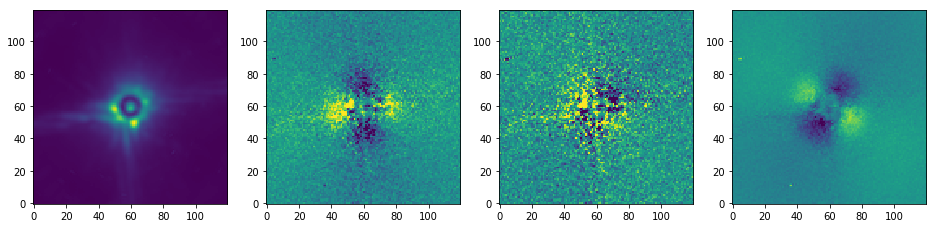

In [45]:
### Plot the output 
fig = plt.figure(figsize=(16,4))
ax1 = fig.add_subplot(141)
plt.imshow(stokes_cube[0])

ax2 = fig.add_subplot(142)
plt.imshow(stokes_cube[1],vmin=-500,vmax=500)

ax3 = fig.add_subplot(143)
plt.imshow(stokes_cube[2],vmin=-500,vmax=500)

ax3 = fig.add_subplot(144)
plt.imshow(stokes_cube[3],vmin=-500,vmax=500)

### Unfortunately (but not unexpected), the mueller matrix puts a lot of the input flux in the Stokes V component. Something is clearly wrong. 

In [36]:
#Save some fits files to 
tst = fits.PrimaryHDU([stokes_cube])
tst.writeto("Stokes.fits",overwrite=True)

In [37]:
p = np.sqrt(stokes_cube[1]**2+stokes_cube[2]**2)
tst = fits.PrimaryHDU([p])
tst.writeto("P.fits",overwrite=True)